# Results rudder velocities

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker

In [3]:
ship_name = "optiwise"

In [4]:
model = catalog.load(f"{ship_name}.models_VCT_MMG_rudder")["MMG"]()
model.control_keys=['u_R','v_R','delta']
rudder = model.subsystems['rudder']
rudder.lambdas.pop('u_R')
rudder.lambdas.pop('v_R')
rudder.lambdas.pop('C_Th')
rudder.lambdas.pop('V_A')
model.parameters['gamma_0']=0
model.parameters['a_H'] = 0
model.parameters['x_H'] = 0

ship_data = model.ship_parameters.copy()

[11/18/24 11:13:54] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=868102;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=463448;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=80729;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=552183;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_VCT_MMG_rudder'                 ]8;id=429649;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=720286;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [5]:
def add_zeros(df, zero_test_types = [
        'Circle',
        'Drift angle',
        'Rudder angle',
    ]):

    ## Add zeros:
    #if 'self propulsion' in df['test type']:
    #    df_self_propulsion = df.groupby('test type').get_group('self propulsion')
    #else:
    #    return df
    df_self_propulsion = df.groupby('test type').get_group('self propulsion')
    zero = df_self_propulsion.loc[df_self_propulsion['V'].idxmax()]
    
    _ = []
    for test_type in zero_test_types:
        new_zero = zero.copy()
        new_zero['test type'] = test_type
        _.append(new_zero)
    
    new_zeros = pd.DataFrame(_)
    
    df = pd.concat((df, new_zeros))

    return df

In [6]:
df_VCT = pd.read_csv("../../notebooks/OPTIWISE/df_VCT_velocities_mean_optiwise.csv", index_col=0)

#mask = df_VCT['r'] > 0
#df_VCT.loc[mask,'v_R']*=-1

#df_VCT = add_zeros(df_VCT)

df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])
mask = df_VCT['beta_deg'].abs() < 20
df_VCT = df_VCT.loc[mask].copy()

In [7]:
#df_VCT['v_R'] = np.sign(df_VCT['v_R**2'])*np.sqrt(np.abs(df_VCT['v_R**2']))
#df_VCT['u_R'] = np.sign(df_VCT['u_R**2'])*np.sqrt(np.abs(df_VCT['u_R**2']))
#df_VCT['V_R'] = np.sign(df_VCT['V_R**2'])*np.sqrt(np.abs(df_VCT['V_R**2']))

## Scale

In [8]:
lpp_ship = ship_data['L']*ship_data['scale_factor']
rho_ = df_VCT.iloc[0]['rho']
prime_system_ship = PrimeSystem(L=lpp_ship, rho=rho_)

In [9]:
def scale(df):
    units={
        'u_R_port':'linear_velocity',
        'v_R_port':'linear_velocity',
        'V_R_port':'linear_velocity',
        'w_R_port':'linear_velocity',
    
        'u_R_stbd':'linear_velocity',
        'v_R_stbd':'linear_velocity',
        'V_R_stbd':'linear_velocity',
        'w_R_stbd':'linear_velocity',

        'u_R':'linear_velocity',
        'v_R':'linear_velocity',
        'V_R':'linear_velocity',
        'w_R':'linear_velocity',
        
        'V_R_port**2':"linear_velocity**2",
        'u_R_port**2':"linear_velocity**2",
        'v_R_port**2':"linear_velocity**2",
        'V_R_stbd**2':"linear_velocity**2",
        'u_R_stbd**2':"linear_velocity**2",
        'v_R_stbd**2':"linear_velocity**2",

        'V_R**2':"linear_velocity**2",
        'u_R**2':"linear_velocity**2",
        'v_R**2':"linear_velocity**2",
        'index_VCT':'-',
        'z':'length',
        'beta_deg':'angle',
    }
    df_prime = prime_system_ship.prime(df, U = df['V'], units=units, only_with_defined_units=True)
    df_scaled = model.prime_system.unprime(df_prime, U=df['V']/np.sqrt(ship_data['scale_factor']), units=units)
    return df_scaled


In [91]:
df_VCT_scaled = scale(df_VCT)
df_VCT_scaled['model_name'] = 'VCT'
df_VCT_scaled['is_VCT'] = True
df_VCT_scaled = add_zeros(df_VCT_scaled)
df_VCT_scaled['gamma'] = np.arctan2(df_VCT_scaled['v_R'],df_VCT_scaled['u_R'])
df_VCT_scaled['gamma_deg'] = np.rad2deg(df_VCT_scaled['gamma'])

In [92]:
rudder = model.subsystems['rudder']
df_prediction_MMG = pd.DataFrame(rudder.calculate_forces(states_dict=df_VCT_scaled[model.states_str], control=df_VCT_scaled[model.control_keys], calculation={}), index=df_VCT_scaled.index)
columns = list(set(df_VCT_scaled.columns) - set(df_prediction_MMG.columns))
df_prediction_MMG[columns] = df_VCT_scaled[columns]
df_prediction_MMG['model_name'] = 'MMG'
df_prediction_MMG['is_VCT'] = False  # For bokeh plottings
df_prediction_MMG['Y_R']*=0.7

In [93]:
df_VCT_scaled_RMS = df_VCT_scaled.copy()
df_VCT_scaled_RMS['v_R'] = np.sign(df_VCT_scaled_RMS['v_R**2'])*np.sqrt(np.abs(df_VCT_scaled_RMS['v_R**2']))
df_VCT_scaled_RMS['u_R'] = np.sign(df_VCT_scaled_RMS['u_R**2'])*np.sqrt(np.abs(df_VCT_scaled_RMS['u_R**2']))
df_VCT_scaled_RMS['V_R'] = np.sign(df_VCT_scaled_RMS['V_R**2'])*np.sqrt(np.abs(df_VCT_scaled_RMS['V_R**2']))
df_VCT_scaled_RMS['gamma'] = np.arctan2(df_VCT_scaled_RMS['v_R'],df_VCT_scaled_RMS['u_R'])
df_VCT_scaled_RMS['gamma_deg'] = np.rad2deg(df_VCT_scaled_RMS['gamma'])


In [94]:
df_prediction_MMG_RMS = pd.DataFrame(rudder.calculate_forces(states_dict=df_VCT_scaled_RMS[model.states_str], control=df_VCT_scaled_RMS[model.control_keys], calculation={}), index=df_VCT_scaled_RMS.index)
columns = list(set(df_VCT_scaled_RMS.columns) - set(df_prediction_MMG_RMS.columns))
df_prediction_MMG_RMS[columns] = df_VCT_scaled_RMS[columns]
df_prediction_MMG_RMS['model_name'] = 'MMG'
df_prediction_MMG_RMS['is_VCT'] = False  # For bokeh plottings
df_prediction_MMG_RMS['Y_R']*=0.7

In [95]:
styles['MMG_rudder ($u_R,v_R$ replace)'] = styles['MMG_rudder']
styles['MMG_rudder ($u_R,v_R$ replace)']['label'] = 'MMG rudder ($u_R,v_R$ replace)'

#styles['MMG_rudder ($RMS(u_R),RMS(v_R)$ replace)'] = {}
#styles['MMG_rudder ($RMS(u_R),RMS(v_R)$ replace)']['label'] = 'MMG rudder ($RMS(u_R),RMS(v_R)$ replace)'
#styles['MMG_rudder ($RMS(u_R),RMS(v_R)$ replace)']['style'] = 'm-'

In [96]:
styles


{
    'VCT': {'style': 'k.-', 'zorder': 100, 'lw': 0.7, 'label': 'VCT'},
    'Experiment': {'style': 'k-', 'zorder': 100, 'lw': 0.7, 'label': 'experiment'},
    'polynomial rudder': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'semiempirical rudder': {'style': 'b-', 'label': 'semi-empirical rudder'},
    'measured rudder': {'style': 'g-', 'zorder': -100, 'alpha': 0.5, 'label': 'measured rudder'},
    'MMG_rudder': {'style': 'c-', 'label': 'MMG rudder ($u_R,v_R$ replace)'},
    'MMG_rudder ($u_R,v_R$ replace)': {'style': 'c-', 'label': 'MMG rudder ($u_R,v_R$ replace)'}
}

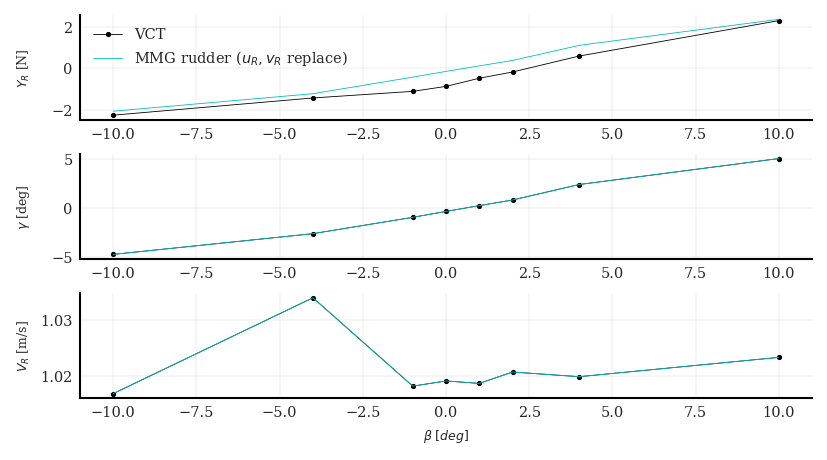

In [97]:
predictions = {
    'MMG_rudder ($u_R,v_R$ replace)':df_prediction_MMG,
    #'MMG_rudder ($RMS(u_R),RMS(v_R)$ replace)':df_prediction_MMG_RMS,
}

fig = plot_VCT(df_VCT_scaled, y_keys=['Y_R','gamma_deg','V_R'], predictions=predictions, test_type='Drift angle', styles=styles);
fig.axes[0].set_ylabel(r'$Y_R$ [N]')
fig.axes[1].set_ylabel(r'$\gamma$ [deg]')
fig.axes[2].set_ylabel(r'$V_R$ [m/s]')

fig.align_ylabels()
fig.suptitle('')
fig.axes[0].set_title('')
fig.axes[1].get_legend().set_visible(False)
fig.axes[2].get_legend().set_visible(False)

for ax in fig.axes:
    ax.grid(True)

paper.save_fig(fig,"drift_angle.svg")

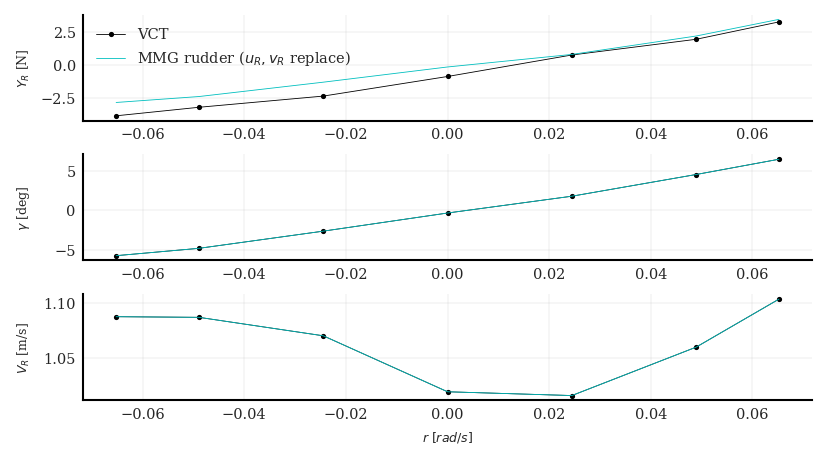

In [98]:
fig = plot_VCT(df_VCT_scaled, y_keys=['Y_R','gamma_deg','V_R'], predictions=predictions, test_type='Circle', styles=styles);
fig.axes[0].set_ylabel(r'$Y_R$ [N]')
fig.axes[1].set_ylabel(r'$\gamma$ [deg]')
fig.axes[2].set_ylabel(r'$V_R$ [m/s]')

fig.align_ylabels()
fig.suptitle('')
fig.axes[0].set_title('')
fig.axes[1].get_legend().set_visible(False)
fig.axes[2].get_legend().set_visible(False)

for ax in fig.axes:
    ax.grid(True)

paper.save_fig(fig,"circle.svg")

In [99]:
df_compare = pd.merge(left=df_VCT_scaled, right=df_prediction_MMG, left_index=True, right_index=True, how='left', suffixes=('','_MMG'))

In [103]:
table = df_compare.loc[[16,10,0,5,],['beta_deg','r','V_R','gamma_deg','Y_R','Y_R_MMG']]

In [106]:
table.to_csv(paper.file_path_with_nb_ref("inflows.csv", directory='tables'), index=False)

In [60]:
df_prediction_MMG.groupby(by='test type').get_group('Circle').sort_values(by='r')[['r','V_R','gamma_deg','Y_R']]

,r,V_R,gamma_deg,Y_R
5,-0.065215,1.087831,-5.724915,-2.855336
6,-0.048911,1.087245,-4.794895,-2.402717
7,-0.024456,1.070330,-2.623125,-1.308649
33,0.000000,1.019040,-0.330028,-0.149243
2,0.024456,1.015575,1.794405,0.806595
1,0.048911,1.059927,4.539388,2.209757
0,0.065215,1.103940,6.470565,3.479733


In [61]:
df_VCT_scaled.groupby(by='test type').get_group('Circle').sort_values(by='r')[['r','V_R','gamma_deg','Y_R']]

,r,V_R,gamma_deg,Y_R
5,-0.065215,1.087831,-5.724915,-3.871231
6,-0.048911,1.087245,-4.794895,-3.221520
7,-0.024456,1.070330,-2.623125,-2.368705
33,0.000000,1.019040,-0.330028,-0.874658
2,0.024456,1.015575,1.794405,0.763801
1,0.048911,1.059927,4.539388,1.960322
0,0.065215,1.103940,6.470565,3.286461


In [62]:
rudder = model.subsystems['rudder']
df = pd.DataFrame()
df['u_R'] = [1,1]
df['v_R'] = [-0.1,0.1]
df[model.states_str] = 0
df['thrust'] = 0
df['delta'] = 0


df_prediction_MMG = pd.DataFrame(rudder.calculate_forces(states_dict=df[model.states_str], control=df[model.control_keys], calculation={}), index=df.index)
columns = list(set(df.columns) - set(df_prediction_MMG.columns))
df_prediction_MMG[columns] = df[columns]
df_prediction_MMG['model_name'] = 'MMG'
df_prediction_MMG['is_VCT'] = False  # For bokeh plottings

In [63]:
df_prediction_MMG[['beta','u_R','v_R','delta','alpha_R','Y_R']]

,beta,u_R,v_R,delta,alpha_R,Y_R
0,0.0,1,-0.1,0,0.099669,-4.00491
1,0.0,1,0.1,0,-0.099669,4.00491


In [64]:
df_VCT_all = pd.read_csv("../../notebooks/OPTIWISE/df_VCT_velocities_optiwise.csv", index_col=0)
df_VCT_all = scale(df_VCT_all)

df_VCT_all['gamma'] = np.arctan2(df_VCT_all['v_R'],df_VCT_all['u_R'])
df_VCT_all['gamma_deg'] = np.rad2deg(df_VCT_all['gamma'])

In [65]:
df_VCT_scaled.groupby('test type').get_group('self propulsion')

,shipflow_version,path,index,cgnsfile_path,name_no_rudder,result_file_path,model_name,test type,name,result_file_path_no_rudder,test type_no_rudder,path_no_rudder,model_name_no_rudder,shipflow_version_no_rudder,index_no_rudder,V,beta,delta,fx,fy,fz,g,mx,my,mz,p,phi,r,rev,rho,thrust,time,torque,u,v,X_D,Y_D,N_D,X_H,Y_H,N_H,X_R,Y_R,N_R,x0,y0,psi,U,twa,tws,thrust_port,thrust_stbd,u_R,v_R,w_R,V_R,x,z,index_VCT,u_R**2,v_R**2,V_R**2,beta_deg,is_VCT,gamma,gamma_deg
33,7.1.00,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,straight,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,VCT,self propulsion,15kn\straight,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,self propulsion,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,Vessel_D_Design_MS_NoRudder,7.1.00,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,0.935783,0.0,-0.0,0.199509,-1.099822,-148.768539,9.80665,0.225357,266.908463,2.565904,0.0,0.0,0.0,10.322635,1000.0,14.130282,0.121268,0.251427,0.935783,-0.0,0.199509,-1.099822,2.565904,-9.825501,-0.225163,0.40983,-1.137913,-0.874658,2.156075,0.0,0.0,0.0,0.935783,0.0,0.0,7.065141,7.065141,0.963746,-0.005551,-0.038385,1.01904,-2.391544,0.189078,33.0,1.115817,-0.02231,1.257001,0.0,True,-0.00576,-0.330028


[11/18/24 11:17:54] WARNING  /tmp/ipykernel_638858/2625711035.py:8: SettingWithCopyWarning:         ]8;id=344862;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=981288;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['v_R**2'] = df['v_R'].abs()*df['v_R']                                            
                                                                                                                   

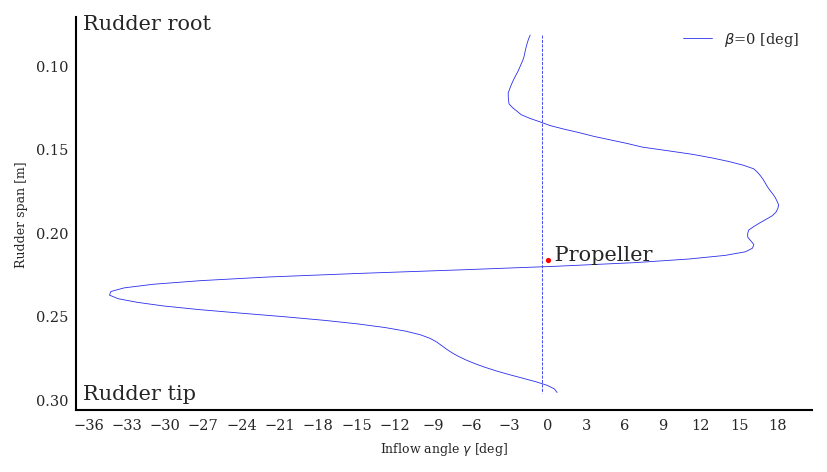

In [66]:
fig,ax=plt.subplots()

for id in [33]:
    label= fr"$\beta$={df_VCT_scaled.loc[id,'beta_deg'].iloc[0]:0.0f} [deg]"
    df = df_VCT_all.groupby(by='index_VCT').get_group(id)
    the_plot = df.plot(x='gamma_deg', y='z', label=label, ax=ax)
    
    df['v_R**2'] = df['v_R'].abs()*df['v_R']
    df_mean = df.mean(numeric_only=True)

    df_mean['v_R_RMS'] = np.sign(df_mean['v_R**2'])*np.sqrt(np.abs(df_mean['v_R**2']))
    df_mean['u_R_RMS'] = np.sign(df_mean['u_R**2'])*np.sqrt(np.abs(df_mean['u_R**2']))
    df_mean['gamma_RMS'] = np.arctan2(df_mean['v_R_RMS'],df_mean['u_R_RMS'])
    df_mean['gamma_deg_RMS'] = np.rad2deg(df_mean['gamma_RMS'])
    
    color = the_plot.lines[-1].get_color()
    ax.plot([df_mean['gamma_deg'],df_mean['gamma_deg']],[df['z'].min(),df['z'].max()],'--', color=color)
    #ax.plot([df_mean['gamma_deg_RMS'],df_mean['gamma_deg_RMS']],[df['z'].min(),df['z'].max()],':', color=color)


z_prop = df['z'].max() - 5.4/ship_data['scale_factor']
ax.plot(0,z_prop,'r.')
ax.text(0,z_prop,' Propeller')


ax.invert_yaxis()
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#ax.yaxis.set_major_locator(loc)
ax.grid(False, axis='x')
ax.grid(False, axis='y')
ax.set_xlabel(r'Inflow angle $\gamma$ [deg]')
ax.set_ylabel(r'Rudder span [m]')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(0.01,0.97,'Rudder root', transform=ax.transAxes)
ax.text(0.01,0.03,'Rudder tip', transform=ax.transAxes)

paper.save_fig(fig, "inflow_angle_straight.svg")

In [90]:
df_prediction_MMG.head()

,eta,beta,beta_R,gamma_R,alpha_R,Lambda,f_alpha,U_R,F_N,X_R,Y_R,N_R,x0,psi,u,delta,v_R,thrust,y0,v,u_R,r,model_name,is_VCT
0,0.721088,0.0,0.0,0.25,0.099669,1.344307,2.292682,1.004988,4.00491,0.0,-4.00491,9.570558,0,0,0,0,-0.1,0,0,0,1,0,MMG,False
1,0.721088,0.0,0.0,0.25,-0.099669,1.344307,2.292682,1.004988,-4.00491,-0.0,4.00491,-9.570558,0,0,0,0,0.1,0,0,0,1,0,MMG,False


[11/18/24 11:17:58] WARNING  /tmp/ipykernel_638858/3019149181.py:8: SettingWithCopyWarning:         ]8;id=725635;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=195623;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['v_R**2'] = df['v_R'].abs()*df['v_R']                                            
                                                                                                                   

                    WARNING  /tmp/ipykernel_638858/3019149181.py:8: SettingWithCopyWarning:         ]8;id=316678;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=974502;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['v_R**2'] = df['v_R'].abs()*df['v_R']                                            
                                                                                                                   

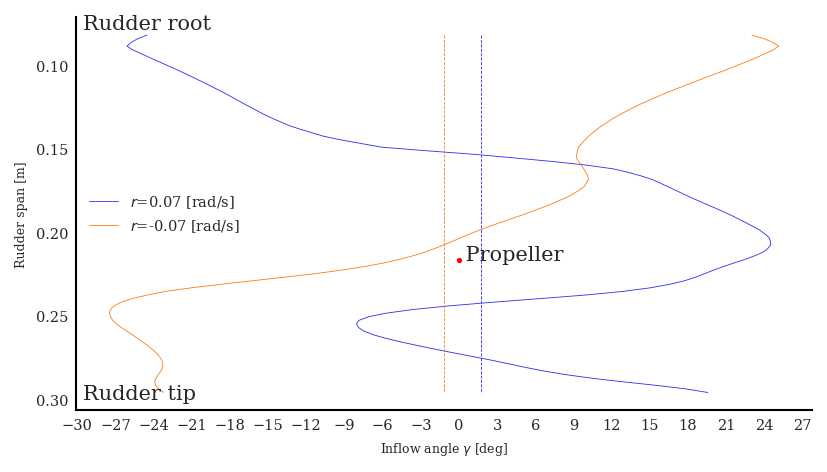

In [68]:
fig,ax=plt.subplots()

for id in [0,5]:
    label= fr"$r$={df_VCT_scaled.loc[id,'r']:0.2f} [rad/s]"
    df = df_VCT_all.groupby(by='index_VCT').get_group(id)
    the_plot = df.plot(x='gamma_deg', y='z', label=label, ax=ax)
    
    df['v_R**2'] = df['v_R'].abs()*df['v_R']
    df_mean = df.mean(numeric_only=True)

    df_mean['v_R_RMS'] = np.sign(df_mean['v_R**2'])*np.sqrt(np.abs(df_mean['v_R**2']))
    
    color = the_plot.lines[-1].get_color()
    ax.plot([df_mean['gamma_deg'],df_mean['gamma_deg']],[df['z'].min(),df['z'].max()],'--', color=color)
    #ax.plot([df_mean['v_R_RMS'],df_mean['v_R_RMS']],[df['z'].min(),df['z'].max()],':', color=color)


z_prop = df['z'].max() - 5.4/ship_data['scale_factor']
ax.plot(0,z_prop,'r.')
ax.text(0,z_prop,' Propeller')


ax.invert_yaxis()
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#ax.yaxis.set_major_locator(loc)
ax.grid(False, axis='x')
ax.grid(False, axis='y')
ax.set_xlabel(r'Inflow angle $\gamma$ [deg]')
ax.set_ylabel(r'Rudder span [m]')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(0.01,0.97,'Rudder root', transform=ax.transAxes)
ax.text(0.01,0.03,'Rudder tip', transform=ax.transAxes)

paper.save_fig(fig, "span_circle.svg")

In [69]:
df_VCT_scaled['C_L'] = (df_VCT_scaled['Y_R']/df_VCT_scaled['V_R']**2)

<Axes: xlabel='gamma'>

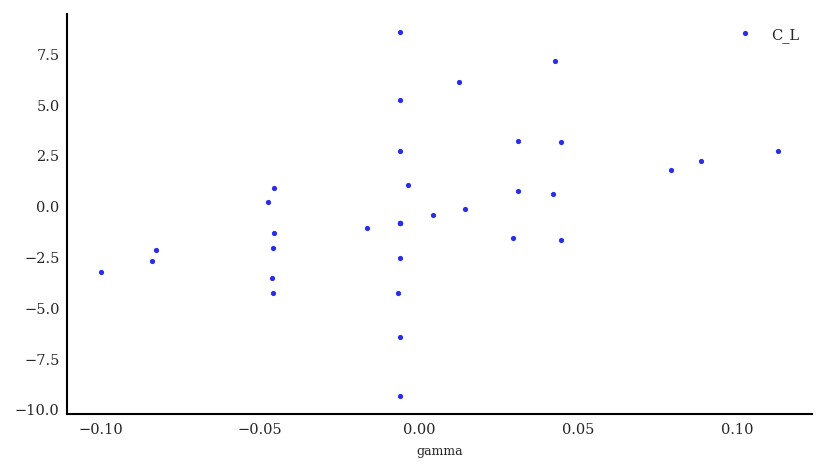

In [70]:
df_VCT_scaled.plot(x='gamma',y='C_L', style='.')

[11/18/24 11:18:01] WARNING  /tmp/ipykernel_638858/3022528372.py:10: SettingWithCopyWarning:        ]8;id=69015;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=267349;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['v_R**2'] = df['v_R'].abs()*df['v_R']                                            
                                                                                                                   

                    WARNING  /tmp/ipykernel_638858/3022528372.py:10: SettingWithCopyWarning:        ]8;id=252509;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=754784;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['v_R**2'] = df['v_R'].abs()*df['v_R']                                            
                                                                                                                   

                    WARNING  /tmp/ipykernel_638858/3022528372.py:23: SettingWithCopyWarning:        ]8;id=911956;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=36148;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['v_R**2'] = df['v_R'].abs()*df['v_R']                                            
                                                                                                                   

                    WARNING  /tmp/ipykernel_638858/3022528372.py:23: SettingWithCopyWarning:        ]8;id=113159;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=972192;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df['v_R**2'] = df['v_R'].abs()*df['v_R']                                            
                                                                                                                   

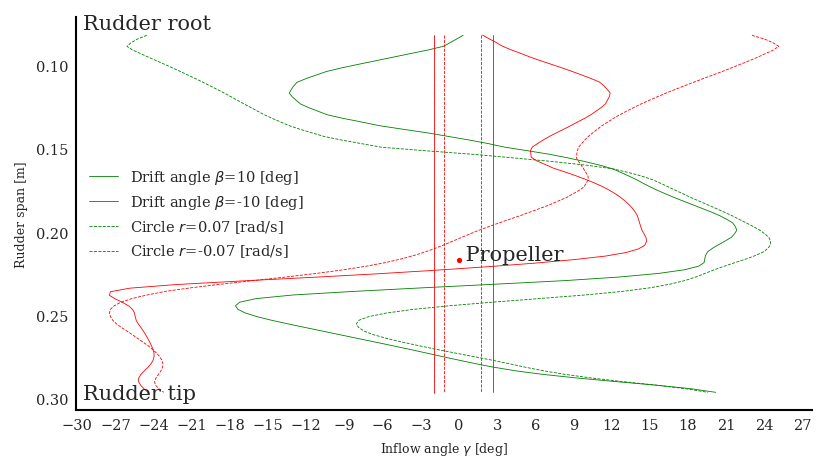

In [71]:
fig,ax=plt.subplots()

colors = ['g','r']
for id in [16,10]:
    label= fr"Drift angle $\beta$={df_VCT_scaled.loc[id,'beta_deg']:0.0f} [deg]"
    df = df_VCT_all.groupby(by='index_VCT').get_group(id)
    color=colors.pop(0)
    the_plot = df.plot(x='gamma_deg', y='z', color=color, label=label, ax=ax)
    
    df['v_R**2'] = df['v_R'].abs()*df['v_R']
    df_mean = df.mean(numeric_only=True)
    
    ax.plot([df_mean['gamma_deg'],df_mean['gamma_deg']],[df['z'].min(),df['z'].max()],'-', color=color)


colors = ['g','r']
for id in [0,5]:
    label= fr"Circle $r$={df_VCT_scaled.loc[id,'r']:0.2f} [rad/s]"
    df = df_VCT_all.groupby(by='index_VCT').get_group(id)
    color=colors.pop(0)
    the_plot = df.plot(x='gamma_deg', y='z', color=color, style='--', label=label, ax=ax)
    
    df['v_R**2'] = df['v_R'].abs()*df['v_R']
    df_mean = df.mean(numeric_only=True)
    
    color = the_plot.lines[-1].get_color()
    ax.plot([df_mean['gamma_deg'],df_mean['gamma_deg']],[df['z'].min(),df['z'].max()],'--', color=color)

z_prop = df['z'].max() - 5.4/ship_data['scale_factor']
ax.plot(0,z_prop,'r.')
ax.text(0,z_prop,' Propeller')


ax.invert_yaxis()
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#ax.yaxis.set_major_locator(loc)
ax.grid(False, axis='x')
ax.grid(False, axis='y')
ax.set_xlabel(r'Inflow angle $\gamma$ [deg]')
ax.set_ylabel(r'Rudder span [m]')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(0.01,0.97,'Rudder root', transform=ax.transAxes)
ax.text(0.01,0.03,'Rudder tip', transform=ax.transAxes)

paper.save_fig(fig, "inflow_angle.svg")